In [1]:
!pip install torch==2.1.2 numpy==1.26.4 pandas

In [2]:
import torch
import numpy as np
import pandas as pd
import random

In [3]:
PAD_TOKEN = -1

In [3]:
# import pandas as pd
# import numpy as np
# import torch

# PAD_TOKEN = 0.0  # or np.nan if you handle it explicitly elsewhere

# def load_fatras_data(fatras_file, particles_file, max_num_hits, normalize=True):
#     '''
#     Load detector hits and particle truth info, matched by particle_id.
#     '''
#     hits = pd.read_csv(fatras_file)
#     particles = pd.read_csv(particles_file)

#     # Merge hits with their generating particle truth info
#     data = hits.merge(
#         particles[["particle_id", "px", "py", "pz", "q"]],
#         on="particle_id", how="left"
#     )
    
#     # For completeness, we can also add synthetic "event_id" if needed
#     data["event_id"] = 0  # If multiple files processed, this needs incrementing

#     # Normalize
#     if normalize:
#         for col in ["tx", "ty", "tz", "px", "py", "pz", "q"]:
#             mean = data[col].mean()
#             std = data[col].std()
#             data[col] = (data[col] - mean) / std

#     # Extract features
#     def extract_hits(event_rows):
#         coords = event_rows[["tx", "ty", "tz"]].to_numpy(np.float32)
#         return np.pad(coords, [(0, max_num_hits - len(coords)), (0, 0)], "constant", constant_values=PAD_TOKEN)

#     def extract_track_params(event_rows):
#         params = event_rows[["px", "py", "pz", "q"]].to_numpy(np.float32)
#         p = np.linalg.norm(params[:, :3], axis=1)
#         theta = np.arccos(params[:, 2] / p)
#         phi = np.arctan2(params[:, 1], params[:, 0])
#         stacked = np.column_stack([theta, np.sin(phi), np.cos(phi), params[:, 3]])
#         return np.pad(stacked, [(0, max_num_hits - len(stacked)), (0, 0)], "constant", constant_values=PAD_TOKEN)

#     def extract_hit_classes(event_rows):
#         classes = event_rows[["particle_id"]].copy()
#         classes["weight"] = 1.0  # default weight
#         return np.pad(classes.to_numpy(np.float32), [(0, max_num_hits - len(classes)), (0, 0)], "constant", constant_values=PAD_TOKEN)

#     # hits_arr = extract_hits(data)
#     # print("Hits shape:", hits_arr.shape)
#     # print("Hits dtype:", hits_arr.dtype)
#     # print("Hits type:", type(hits_arr))
#     # print("Sample values:", hits_arr[:5])
#     # print("Columns in DataFrame:", data.columns)
#     # print("Any NaNs in tx/ty/tz?", data[["tx", "ty", "tz"]].isnull().any())
    
#     # v1 worked
#     # hits_tensor = torch.tensor(extract_hits(data))
#     # track_params_tensor = torch.tensor(extract_track_params(data))
#     # hit_classes_tensor = torch.tensor(extract_hit_classes(data))

#     # v2 -- didnt work
#     # hits_tensor = torch.tensor(extract_hits(data).astype(np.float32))
#     # track_params_tensor = torch.tensor(extract_track_params(data).astype(np.float32))
#     # hit_classes_tensor = torch.tensor(extract_hit_classes(data).astype(np.float32))

#     # v3
#     hits_tensor = torch.from_numpy(extract_hits(data))
#     track_params_tensor = torch.from_numpy(extract_track_params(data))
#     hit_classes_tensor = torch.from_numpy(extract_hit_classes(data))

    


#     return hits_tensor, track_params_tensor, hit_classes_tensor

In [25]:
def load_fatras_data(hits_file, particles_file, truth_file, max_num_hits, normalize=True, chunking=False):
    '''
    Function for reading TrackML .csv files (hits, particles, truth) and creating tensors
    for the hits, track parameters, and particle information.
    
    Parameters:
        hits_file (str): Path to the hits.csv file
        particles_file (str): Path to the particles.csv file
        truth_file (str): Path to the truth.csv file
        max_num_hits (int): Maximum number of hits to pad to
        normalize (bool): Whether to normalize features
        chunking (bool): Whether CSVs should be read in chunks
    '''
    if chunking:
        raise NotImplementedError("Chunking not implemented for this loader.")

    # Load CSVs
    hits = pd.read_csv(hits_file)
    particles = pd.read_csv(particles_file)
    truth = pd.read_csv(truth_file)

    # Merge hits with truth on hit_id
    data = hits.merge(truth, on="hit_id", how="left")
    # Merge with particle properties on particle_id
    data = data.merge(particles[["particle_id", "px", "py", "pz", "q"]], on="particle_id", how="left")

    # Assign synthetic event_id (could be set dynamically in batch loading)
    data["event_id"] = 0

    # # Normalize selected columns
    # if normalize:
    #     for col in ["x", "y", "z", "px", "py", "pz", "q"]:
    #         mean = data[col].mean()
    #         std = data[col].std()
    #         if std != 0:
    #             data[col] = (data[col] - mean) / std

    # Shuffle and group by event (here, only one event typically)
    data_grouped_by_event = data.groupby("event_id")

    def extract_hits_data(event_rows):
        coords = event_rows[["x", "y", "z"]].to_numpy(np.float32)
        return np.pad(coords, [(0, max_num_hits - len(coords)), (0, 0)], "constant", constant_values=PAD_TOKEN)

    def extract_track_params_data(event_rows):
        params = event_rows[["px", "py", "pz", "q"]].to_numpy(np.float32)
        p = np.linalg.norm(params[:, :3], axis=1)
        theta = np.arccos(params[:, 2] / p)
        phi = np.arctan2(params[:, 1], params[:, 0])
        return np.pad(np.column_stack([theta, np.sin(phi), np.cos(phi), params[:, 3]]),
                      [(0, max_num_hits - len(params)), (0, 0)], "constant", constant_values=PAD_TOKEN)

    def extract_hit_classes_data(event_rows):
        class_data = event_rows[["particle_id", "weight"]].to_numpy(np.float32)
        return np.pad(class_data, [(0, max_num_hits - len(class_data)), (0, 0)], "constant", constant_values=PAD_TOKEN)

    # Extract and pad for each event
    hits_data = torch.tensor(np.stack(data_grouped_by_event.apply(extract_hits_data).values))
    track_params_data = torch.tensor(np.stack(data_grouped_by_event.apply(extract_track_params_data).values))
    hit_classes_data = torch.tensor(np.stack(data_grouped_by_event.apply(extract_hit_classes_data).values))

    return hits_data, track_params_data, hit_classes_data

In [37]:
hits_file = 'data/ttbar_H_production_p50/csv/background/tml_dataset/event000019999-hits.csv'
particles_file = 'data/ttbar_H_production_p50/csv/background/tml_dataset/event000019999-particles.csv'
truth_file = 'data/ttbar_H_production_p50/csv/background/tml_dataset/event000019999-truth.csv'

max_hits = 30000
hits_tensor, track_params_tensor, hit_classes_tensor = load_fatras_data(hits_file, particles_file, truth_file, max_hits)


/tmp/ipykernel_4287/3012343104.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hits_data = torch.tensor(np.stack(data_grouped_by_event.apply(extract_hits_data).values))
/tmp/ipykernel_4287/3012343104.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  track_params_data = torch.tensor(np.stack(data_grouped_by_event.apply(extract_track_params_data).values))
/tmp/ipykernel_4287/3012343104.py:60: Deprecat

In [19]:
path_hits = r'data/ttbar_H_production_p50/csv/background/tml_dataset'
path_particles = r'data/ttbar_H_production_p50/csv/background/tml_dataset'

max_hits = 120000

In [20]:
hits_data, track_params_data, hit_classes_data = load_fatras_data(path_hits, path_particles, max_hits)

FileNotFoundError: [Errno 2] No such file or directory: 'data/ttbar_H_production/csv/background/tml_dataset/event000019999-hits.csv'

In [7]:
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 26.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 85.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 125.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 167.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [seaborn]m6/8 [matplotlib]


In [38]:
import os

import numpy as np
import pandas as pd

from tqdm import tqdm

# from trackml.dataset import load_event
# from trackml.randomize import shuffle_hits
# from trackml.score import score_event

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline

In [39]:
# path_hits = r'ttbar_H_production/csv/signal/event000000000-fatras_hits.csv'
path_hits = r'data/ttbar_H_production_p50/csv/signal/digitization/event000000000-measurements_global_xyz.csv'
hits = pd.read_csv(path_hits)

In [40]:
hits["r"] = np.sqrt(hits["tx"]**2 + hits["ty"]**2)
# hits["volume_id"] = pd.cut(hits["r"], bins=[0, 100, 300, 600, 900, 1200, 1500], labels=[1, 2, 3, 4, 5, 6])

KeyError: 'tx'

In [ ]:
hits.volume_id.unique()

In [41]:
print(hits[["geometry_id", "volume_id"]].head())

KeyError: "['volume_id'] not in index"

100%|██████████| 9/9 [00:00<00:00, 325.05it/s]


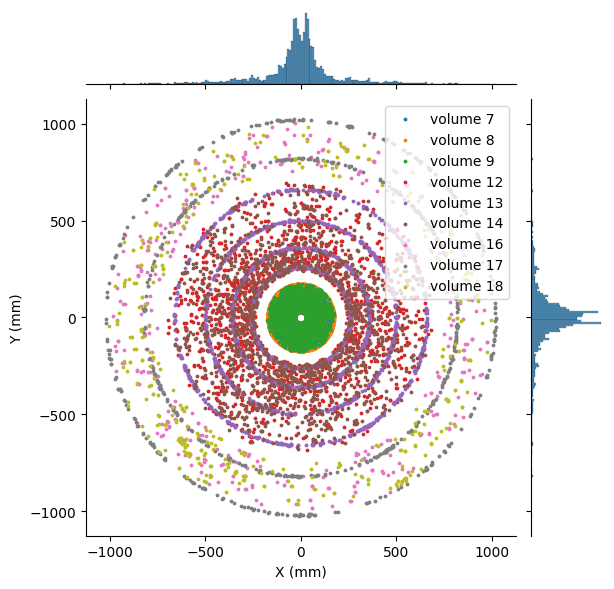

In [42]:
g = sns.jointplot(data=hits, x='global_x', y='global_y', s=1, size=12)
g.ax_joint.cla()
plt.sca(g.ax_joint)

volumes = hits.volume.unique()
for volume in tqdm(volumes):
    v = hits[hits.volume == volume]
    plt.scatter(v.global_x, v.global_y, s=3, label='volume {}'.format(volume))

# plt.scatter(hits.tx, hits.ty, s=3, label='volume {}'.format(1))
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.legend()
plt.show()

100%|██████████| 9/9 [00:00<00:00, 344.89it/s]


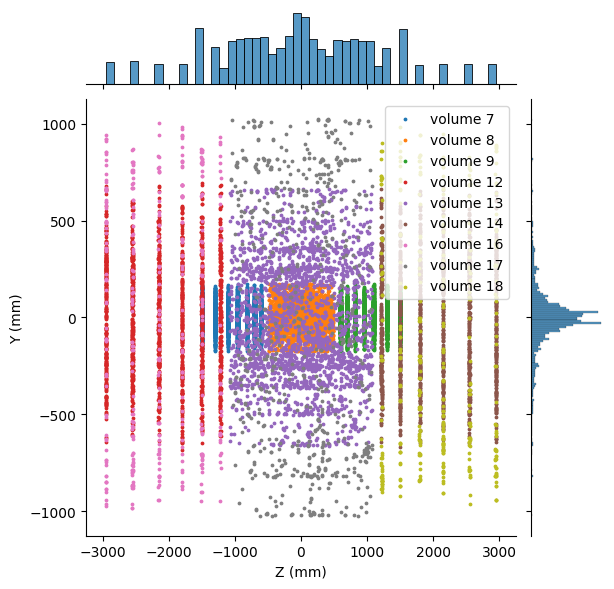

In [15]:
g = sns.jointplot(data=hits, x='global_z', y='global_y', s=1, size=12)
g.ax_joint.cla()
plt.sca(g.ax_joint)

volumes = hits.volume.unique()
for volume in tqdm(volumes):
    v = hits[hits.volume == volume]
    plt.scatter(v.global_z, v.global_y, s=3, label='volume {}'.format(volume))

plt.xlabel('Z (mm)')
plt.ylabel('Y (mm)')
plt.legend()
plt.show()


100%|██████████| 9/9 [00:00<00:00, 343.04it/s]


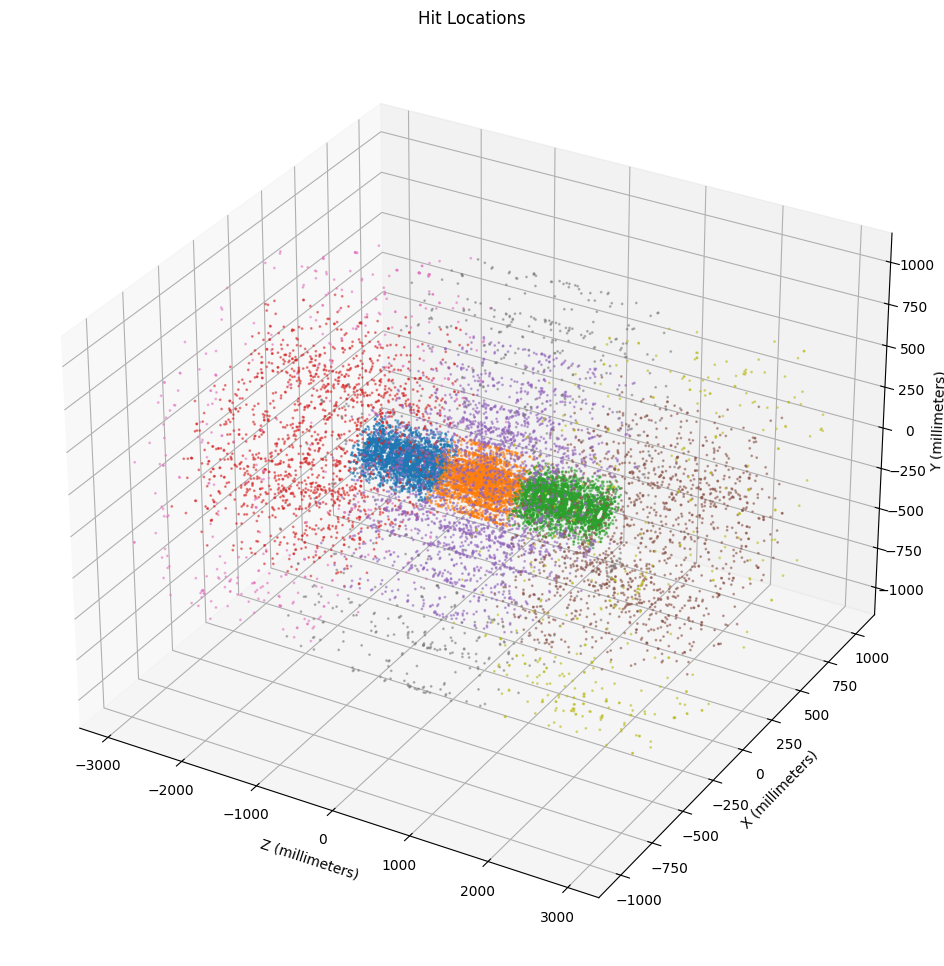

In [16]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
for volume in tqdm(volumes):
    v = hits[hits.volume == volume]
    ax.scatter(v.global_z, v.global_x, v.global_y, s=1, label='volume {}'.format(volume), alpha=0.5)
ax.set_title('Hit Locations')
ax.set_xlabel('Z (millimeters)')
ax.set_ylabel('X (millimeters)')
ax.set_zlabel('Y (millimeters)')
plt.show()

In [3]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm

PAD_TOKEN = 0.0

class FatrasTrackDataset(Dataset):
    def __init__(self, base_dir, normalize=True, max_num_hits=None):
        """
        base_dir: path to 'csv/' folder
        normalize: whether to normalize features
        max_num_hits: if None, it will be determined automatically
        """
        self.base_dir = Path(base_dir)
        self.normalize = normalize
        self.max_num_hits = max_num_hits
        self.events = []

        # Collect events from both signal and background with progress bar
        for label, class_name in [(1, "signal"), (0, "background")]:
            class_dir = self.base_dir / class_name
            print(f"[INFO] Scanning {class_name} directory...")
            fatras_files = list(class_dir.glob("*-fatras_hits.csv"))
            event_basenames = sorted(set(
                f.stem.replace("-fatras_hits", "")
                for f in tqdm(fatras_files, desc=f"Processing {class_name}")
                if (class_dir / f"{f.stem.replace('-fatras_hits', '')}-particles.csv").exists()
            ))
            self.events.extend([
                {"basename": e, "dir": class_dir, "label": label}
                for e in event_basenames
            ])

        if not self.events:
            raise ValueError("No valid events found in the provided path.")

        # Shuffle all events
        np.random.shuffle(self.events)

        # Determine max_num_hits if not provided
        if self.max_num_hits is None:
            print("[INFO] Determining max_num_hits automatically...")
            self.max_num_hits = max(
                len(pd.read_csv(event["dir"] / f"{event['basename']}-fatras_hits.csv"))
                for event in tqdm(self.events, desc="Counting hits")
            )
            print(f"[INFO] max_num_hits set to {self.max_num_hits}")

    def __len__(self):
        return len(self.events)

    def __getitem__(self, idx):
        event = self.events[idx]
        basename = event["basename"]
        event_dir = event["dir"]
        label = event["label"]

        hit_file = event_dir / f"{basename}-fatras_hits.csv"
        particle_file = event_dir / f"{basename}-particles.csv"

        hits = pd.read_csv(hit_file)
        particles = pd.read_csv(particle_file)

        # Merge by particle_id
        data = hits.merge(particles[["particle_id", "px", "py", "pz", "q"]], on="particle_id", how="left")

        if self.normalize:
            for col in ["tx", "ty", "tz", "px", "py", "pz", "q"]:
                mean = data[col].mean()
                std = data[col].std()
                if std > 0:
                    data[col] = (data[col] - mean) / std

        def extract_hits(event_rows):
            coords = event_rows[["tx", "ty", "tz"]].to_numpy(np.float32)[:self.max_num_hits]
            return np.pad(coords, [(0, self.max_num_hits - len(coords)), (0, 0)], "constant", constant_values=PAD_TOKEN)

        def extract_track_params(event_rows):
            params = event_rows[["px", "py", "pz", "q"]].to_numpy(np.float32)[:self.max_num_hits]
            p = np.linalg.norm(params[:, :3], axis=1)
            theta = np.arccos(np.clip(params[:, 2] / p, -1, 1))
            phi = np.arctan2(params[:, 1], params[:, 0])
            stacked = np.column_stack([theta, np.sin(phi), np.cos(phi), params[:, 3]])
            return np.pad(stacked, [(0, self.max_num_hits - len(stacked)), (0, 0)], "constant", constant_values=PAD_TOKEN)

        def extract_hit_classes(event_rows):
            classes = event_rows[["particle_id"]].copy()
            classes["weight"] = 1.0
            classes = classes[:self.max_num_hits]
            return np.pad(classes.to_numpy(np.float32), [(0, self.max_num_hits - len(classes)), (0, 0)], "constant", constant_values=PAD_TOKEN)

        return (
            torch.tensor(extract_hits(data)),
            torch.tensor(extract_track_params(data)),
            torch.tensor(extract_hit_classes(data)),
            torch.tensor(label, dtype=torch.long)
        )

In [6]:
dataset = FatrasTrackDataset("ttbar_H_production/csv", normalize=True, max_num_hits=130000)
loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

[INFO] Scanning signal directory...



Processing signal: 100%|██████████| 1000/1000 [00:00<00:00, 63765.51it/s]


[INFO] Scanning background directory...



Processing background: 100%|██████████| 1000/1000 [00:00<00:00, 66239.80it/s]


In [15]:
import torch
from torch.utils.data import DataLoader
from torch.nn import functional as F

# # Your dataset
# dataset = FatrasTrackDataset("ttbar_H_production/csv", normalize=True)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=True)

In [16]:
for batch in dataloader:
    hits, track_params, hit_classes, labels = batch
    print(hits)
    break

tensor([[[-2.0266e-01, -1.4129e-02, -1.2126e+00],
         [-2.3177e-01, -2.0533e-03, -1.2126e+00],
         [-1.5383e-01,  7.0067e-03, -1.2126e+00],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[-3.1059e-01, -2.9546e-02, -1.2163e+00],
         [-3.6773e-01, -4.1972e-02, -1.2163e+00],
         [-3.7325e-01, -4.0608e-04, -1.2163e+00],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[-3.4877e-01, -8.2961e-02, -1.1942e+00],
         [-2.8107e-01, -3.3352e-02, -1.1942e+00],
         [-1.6579e-01, -8.0738e-03, -1.1942e+00],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        ...,

        [[-1.4488e-01, -2.7276e-02, -1

In [43]:
def load_trackml_data(data, max_num_hits, normalize=True, chunking=False):
    '''
    Function for reading .csv file with TrackML data and creating tensors
    containing the hits and ground truth information from it.
    max_num_hits denotes the size of the largest event, to pad the other events
    up to. normalize decides whether the data will be normalized first. 
    chunking allows for reading .csv files in chunks.
    '''
    if not chunking:
        data = pd.read_csv(data)

    # Normalize the data if applicable
    if normalize:
        for col in ["x", "y", "z", "px", "py", "pz", "q"]:
            mean = data[col].mean()
            std = data[col].std()
            data[col] = (data[col] - mean)/std

    # Shuffling the data and grouping by event ID
    shuffled_data = data.sample(frac=1)
    data_grouped_by_event = shuffled_data.groupby("event_id")

    def extract_hits_data(event_rows):
        # Returns the hit coordinates as a padded sequence; this is the input to the transformer
        event_hit_data = event_rows[["x", "y", "z"]].to_numpy(dtype=np.float32)
        return np.pad(event_hit_data, [(0, max_num_hits-len(event_rows)), (0, 0)], "constant", constant_values=PAD_TOKEN)

    def extract_track_params_data(event_rows):
        # Returns the track parameters as a padded sequence; this is what the transformer must regress
        event_track_params_data = event_rows[["px","py","pz","q"]].to_numpy(dtype=np.float32)
        p = np.sqrt(event_track_params_data[:,0]**2 + event_track_params_data[:,1]**2 + event_track_params_data[:,2]**2)
        theta = np.arccos(event_track_params_data[:,2]/p)
        phi = np.arctan2(event_track_params_data[:,1], event_track_params_data[:,0])
        processed_event_track_params_data = np.column_stack([theta, np.sin(phi), np.cos(phi), event_track_params_data[:,3]])
        return np.pad(processed_event_track_params_data, [(0, max_num_hits-len(event_rows)), (0, 0)], "constant", constant_values=PAD_TOKEN)

    def extract_hit_classes_data(event_rows):
        # Returns the particle information as a padded sequence; this is used for weighting in the calculation of trackML score
        event_hit_classes_data = event_rows[["particle_id","weight"]].to_numpy(dtype=np.float32)
        return np.pad(event_hit_classes_data, [(0, max_num_hits-len(event_rows)), (0, 0)], "constant", constant_values=PAD_TOKEN)

    # Get the hits, track params and their weights as sequences padded up to a max length
    grouped_hits_data = data_grouped_by_event.apply(extract_hits_data)
    grouped_track_params_data = data_grouped_by_event.apply(extract_track_params_data)
    grouped_hit_classes_data = data_grouped_by_event.apply(extract_hit_classes_data)

    # Stack them together into one tensor
    hits_data = torch.tensor(np.stack(grouped_hits_data.values))
    track_params_data = torch.tensor(np.stack(grouped_track_params_data.values))
    hit_classes_data = torch.tensor(np.stack(grouped_hit_classes_data.values))

    return hits_data, track_params_data, hit_classes_data

In [44]:
path_hits = r'ttbar_H_production/csv/signal/event000000000-fatras_hits.csv'
hits = pd.read_csv(path_hits)

FileNotFoundError: [Errno 2] No such file or directory: 'ttbar_H_production/csv/signal/event000000000-fatras_hits.csv'